# Project 1.1: Object Detection in Urban Environments
## Part 2: Exploring the dataset — Statistics
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Compute the class label distributions; 
* Visualise a few images and their bounding box annotations.

## 1. Introduction

In this notebook we will be analysing the first 100 `segment` files of the Waymo Open Dataset [1]. The version 1.2 of this dataset is hosted on a private Google Cloud Storage bucket. To request access to the dataset, visit https://waymo.com/open.

Each segment is a 20-second long clip of images and corresponding label annotations. Images in this dataset were captured at 10 Hz intervals and are said to cover a diverse set of driving conditions, weather patterns, time-of-day ranges and locations. In their [introductory paper](https://paperswithcode.com/dataset/waymo-open-dataset), Sun et al., claim a total of 1950 segments. In this notebook, we will start our analyses by considering only the first 100. Each segment is stored as a `.tfrecord`-formatted file with a serialised data structure described in the corresponding [`dataset.proto`](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) and [`label.proto`](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/label.proto). Contained in the segment files are sensor data collected from a multi-camera, multi-sensor rig attached to the ego vehicle (the Waymo Driver).

The sensor data includes:

* 1 mid-range LiDAR;
* 4 short-range LiDAR;
* 5 cameras (front and sides);
* Synchronised LiDAR and camera data;
* Sensor calibrations and vehicle poses.

In addition to the sensor data, Waymo also includes ground-truth annotations for a variety of classes covering both LiDAR and camera data.

The labelled data includes:

* Labels for 4 object classes — _Vehicles_, _Pedestrians_, _Cyclists_, and _Signs_;
* High-quality labels for LiDAR data in 1200 segments;
* 12,6M 3D bounding box labels with tracking ID:s on LiDAR data;
* High-quality labels for camera data in 1000 segments;
* 11,8M 2D bounding box labels with tracking ID:s on camera data.


In our analysis, we will only be considering the LiDAR ("LASER") and camera ("CAMERA") labels. Specifically, in this notebook, we will take a look at the `.csv` file we derived in the [previous notebook](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/1-1-Object-Detection-2D/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments/scripts/data_analysis/2022-10-08-Downloading-and-Extracting-Data.ipynb). We will plot the various class label distributions and scene metadata across locations, weather, time-of-day, and sensor type.

In [1]:
### Installing the Waymo Open Dataset and TensorFlow Object Detection APIs

In [ ]:
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
### Installing the Waymo Open Dataset API and dependencies
!pip3 install --quiet --upgrade pip
!pip3 install --quiet numpy==1.19.2
!pip3 install --quiet waymo-open-dataset-tf-2-6-0==1.4.9
!sudo apt-get install --assume-yes pkg-config zip g++ zlib1g-dev unzip python3 python3-pip > /dev/null
!wget https://github.com/bazelbuild/bazel/releases/download/3.1.0/bazel-3.1.0-installer-linux-x86_64.sh > /dev/null
!sudo bash bazel-3.1.0-installer-linux-x86_64.sh > /dev/null
!sudo apt install build-essential > /dev/null
### Installing the build requirements via Bazel
!cd waymo-od && ./configure.sh && cat .bazelrc && bazel clean
### Fetching the TF models/research/object_detection subdirectory
!apt install subversion > /dev/null
!svn checkout -q https://github.com/tensorflow/models/trunk/research/object_detection
!pip install protobuf > /dev/null
### Compiling the protobufs
!pip install protobuf-compiler > /dev/null
!protoc object_detection/protos/*.proto --python_out=.
### Installing the COCO API dependency
!pip install cython > /dev/null
!pip install pycocotools > /dev/null
!cp object_detection/packages/tf2/setup.py .
!pip install . > /dev/null
### Verifying installation was successful
!python3 object_detection/builders/model_builder_tf2_test.py

In [3]:
### Importing the required modules

In [4]:
from collections import Counter, namedtuple
import logging
from matplotlib import colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import pandas as pd
from typing import List, Tuple, TypeVar

In [5]:
### Import the Waymo OD and TFDS Object Detection API utils
import tensorflow as tf
import google.protobuf
from object_detection.utils import dataset_util, label_map_util
import waymo_open_dataset
from waymo_open_dataset import dataset_pb2 as open_dataset

In [6]:
tf.__version__

'2.10.0'

In [7]:
tf.test.gpu_device_name()

''

In [8]:
### Setting the environment variables

In [9]:
ENV_COLAB = True                # True if running in Google Colab instance

In [10]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [11]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [12]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_SRC, exist_ok=True)
os.makedirs(DIR_OUT, exist_ok=True)

## 2. Programming Task

In [13]:
df = pd.read_csv('/content/waymo_object_counts_data_100.csv', sep=';')
df.drop(columns=['Unnamed: 0'])

segment  \
0      segment-10017090168044687777_6380_000_6400_000...   
1      segment-10017090168044687777_6380_000_6400_000...   
2      segment-10017090168044687777_6380_000_6400_000...   
3      segment-10017090168044687777_6380_000_6400_000...   
4      segment-10017090168044687777_6380_000_6400_000...   
...                                                  ...   
19996  segment-12208410199966712301_4480_000_4500_000...   
19997  segment-12208410199966712301_4480_000_4500_000...   
19998  segment-12208410199966712301_4480_000_4500_000...   
19999  segment-12208410199966712301_4480_000_4500_000...   
20000  segment-12208410199966712301_4480_000_4500_000...   

                                         name time_of_day     location  \
0      10017090168044687777_6380_000_6400_000         Day  location_sf   
1      10017090168044687777_6380_000_6400_000         Day  location_sf   
2      10017090168044687777_6380_000_6400_000         Day  location_sf   
3      10017090168044687777_6380_000_6400_000         Day  location_sf   
4      10017090168044687777_6380_000_6400_000         Day  location_sf   
...                                       ...         ...          ...   
19996  12208410199966712301_4480_000_4500_000         Day  location_sf   
19997  12208410199966712301_4480_000_4500_000         Day  location_sf   
19998  12208410199966712301_4480_000_4500_000         Day  location_sf   
19999  12208410199966712301_4480_000_4500_000         Day  location_sf   
20000  12208410199966712301_4480_000_4500_000         Day  location_sf   

      weather  TYPE_VEHICLE_LASER  TYPE_SIGN_LASER  TYPE_VEHICLE_CAMERA  \
0       sunny                 7.0              9.0                  7.0   
1       sunny                 7.0              9.0                  7.0   
2       sunny                 7.0             10.0                  8.0   
3       sunny                 7.0             10.0                  9.0   
4       sunny                 9.0             10.0                 10.0   
...       ...                 ...              ...                  ...   
19996   sunny                41.0              9.0                 36.0   
19997   sunny                42.0              9.0                 39.0   
19998   sunny                42.0              9.0                 38.0   
19999   sunny                42.0              9.0                 39.0   
20000   sunny                43.0              9.0                 39.0   

       TYPE_PEDESTRIAN_CAMERA  TYPE_PEDESTRIAN_LASER  TYPE_CYCLIST_CAMERA  \
0                         NaN                    NaN                  NaN   
1                         NaN                    NaN                  NaN   
2                         NaN                    NaN                  NaN   
3                         NaN                    NaN                  NaN   
4                         NaN                    NaN                  NaN   
...                       ...                    ...                  ...   
19996                     1.0                    1.0                  NaN   
19997                     1.0                    1.0                  NaN   
19998                     1.0                    1.0                  NaN   
19999                     1.0                    1.0                  NaN   
20000                     1.0                    1.0                  NaN   

       TYPE_CYCLIST_LASER  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
19996                 NaN  
19997                 NaN  
19998                 NaN  
19999                 NaN  
20000                 NaN  

[20001 rows x 12 columns]

### 2.1. Class distributions

#### Sensor type

In [14]:
### Explain differences between camera and laser

In [15]:
camera_labels = ['TYPE_VEHICLE_CAMERA', 'TYPE_PEDESTRIAN_CAMERA',
                 'TYPE_CYCLIST_CAMERA'
                ]   
laser_labels = ['TYPE_VEHICLE_LASER', 'TYPE_CYCLIST_LASER',
                'TYPE_PEDESTRIAN_LASER', 'TYPE_SIGN_LASER'
               ]
sensor_types = [camera_labels, laser_labels]

Text(0.5, 1.0, 'Sensor label distributions from 100 segments')

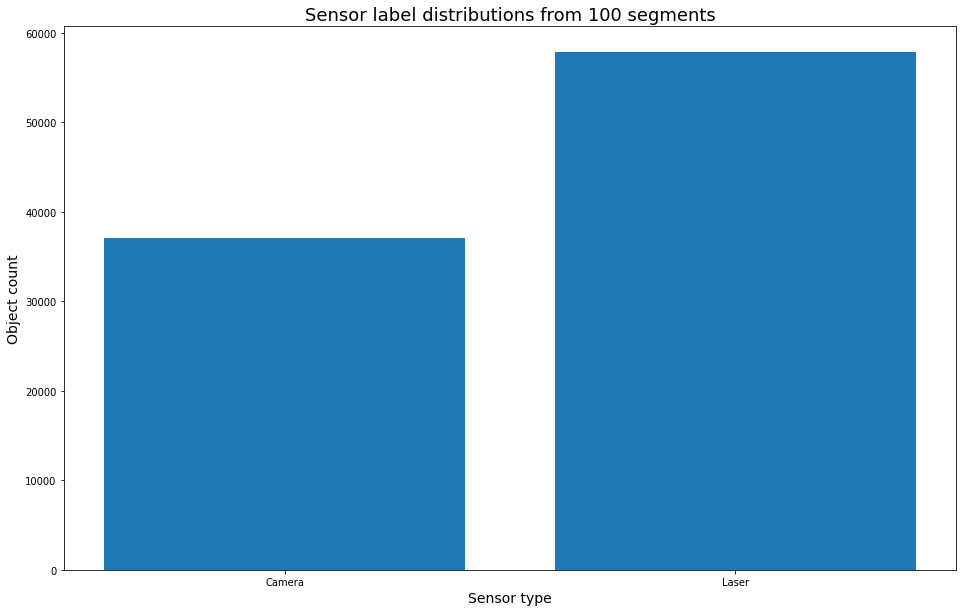

In [16]:
plt.figure(figsize=(16,10))
plt.bar(['Camera', 'Laser'], 
        [sum([df[l].count() for l in st]) for st in sensor_types]
)
plt.xlabel('Sensor type', fontsize=14)
plt.ylabel('Object count', fontsize=14)
plt.title('Sensor label distributions from 100 segments', fontsize=18)

In [17]:
### Explain sign label class

#### Objects

In [18]:
### Ignoring 'sign' class since it isn't present in camera data

In [19]:
object_labels = ['TYPE_VEHICLE_CAMERA', 'TYPE_VEHICLE_LASER', 
                 'TYPE_CYCLIST_CAMERA', 'TYPE_CYCLIST_LASER',
                 'TYPE_PEDESTRIAN_CAMERA', 'TYPE_PEDESTRIAN_LASER'
                ]

Text(0.5, 1.0, 'Class label distributions from 100 segments')

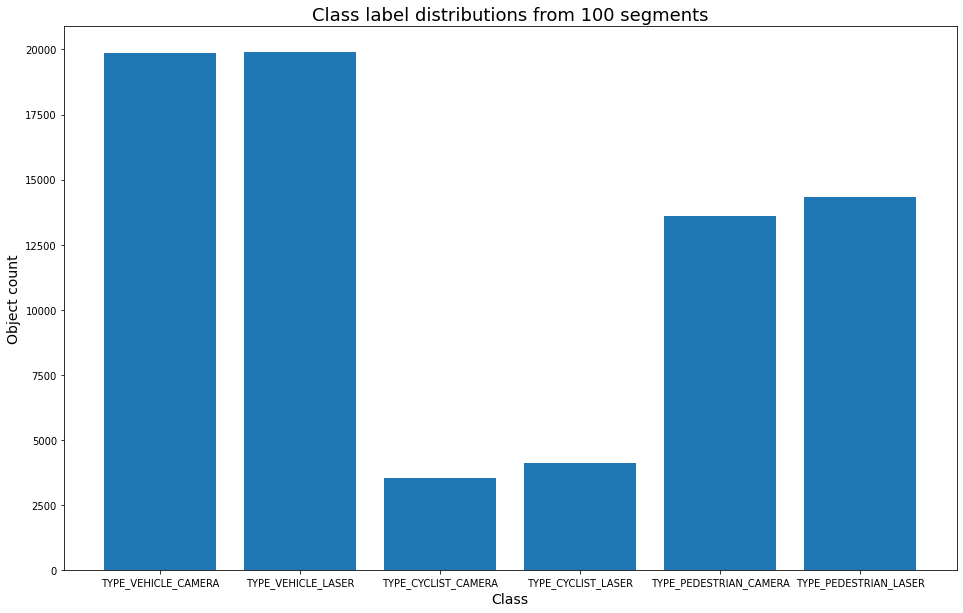

In [21]:
plt.figure(figsize=(16,10))
plt.bar(object_labels, [df[label].count() for label in object_labels])
plt.xlabel('Class', fontsize=14)
plt.ylabel('Object count', fontsize=14)
plt.title('Class label distributions from 100 segments', fontsize=18)

### 2.2. Scene metadata

#### Location

In [23]:
locations = df['location'].unique()

Text(0.5, 1.0, 'Location distributions from 100 segments')

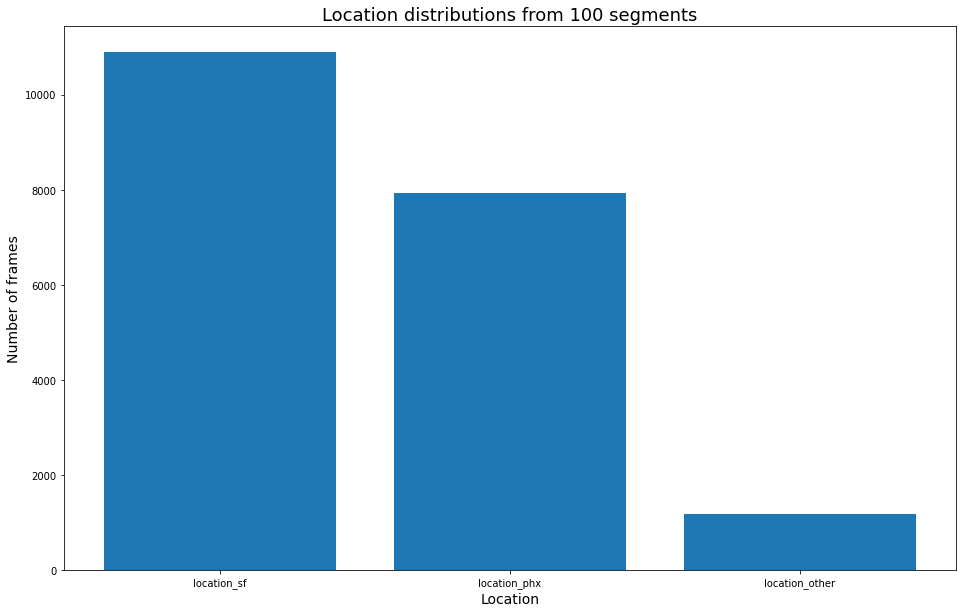

In [24]:
plt.figure(figsize=(16,10))
plt.bar(locations, [df['location'].loc[df['location'] == l].count() for l in locations])
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of frames', fontsize=14)
plt.title('Location distributions from 100 segments', fontsize=18)

In [25]:
### Mean average number of objects per location

In [26]:
df.groupby('location').mean().round()[object_labels]

TYPE_VEHICLE_CAMERA  TYPE_VEHICLE_LASER  TYPE_CYCLIST_CAMERA  \
location                                                                       
location_other                 33.0                32.0                  1.0   
location_phx                   36.0                23.0                  1.0   
location_sf                    42.0                38.0                  2.0   

                TYPE_CYCLIST_LASER  TYPE_PEDESTRIAN_CAMERA  \
location                                                     
location_other                 1.0                     5.0   
location_phx                   1.0                     9.0   
location_sf                    2.0                    24.0   

                TYPE_PEDESTRIAN_LASER  
location                               
location_other                    5.0  
location_phx                      8.0  
location_sf                      27.0

#### Time-of-day

In [28]:
### Explain the 'stats' time_of_day', 'location' and 'weather'

In [29]:
tod_labels = df['time_of_day'].unique()

Text(0.5, 1.0, 'Time of day distributions from 100 segments')

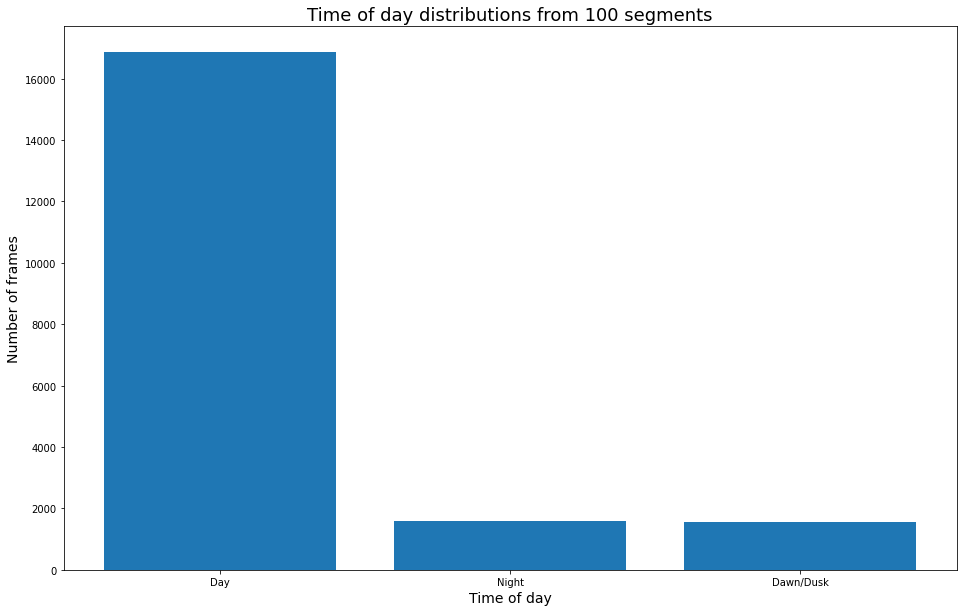

In [30]:
plt.figure(figsize=(16,10))
plt.bar(tod_labels, [df['time_of_day'].loc[df['time_of_day'] == t].count() for t in tod_labels])
plt.xlabel('Time of day', fontsize=14)
plt.ylabel('Number of frames', fontsize=14)
plt.title('Time of day distributions from 100 segments', fontsize=18)

In [31]:
### Mean average object counts based on time-of-day (histogram)

In [32]:
df.groupby('time_of_day').mean().round()[object_labels]

TYPE_VEHICLE_CAMERA  TYPE_VEHICLE_LASER  TYPE_CYCLIST_CAMERA  \
time_of_day                                                                 
Dawn/Dusk                   28.0                23.0                  2.0   
Day                         42.0                33.0                  2.0   
Night                       21.0                21.0                  1.0   

             TYPE_CYCLIST_LASER  TYPE_PEDESTRIAN_CAMERA  TYPE_PEDESTRIAN_LASER  
time_of_day                                                                     
Dawn/Dusk                   1.0                    28.0                   28.0  
Day                         2.0                    20.0                   22.0  
Night                       1.0                     6.0                    7.0

#### Weather

In [35]:
### Getting the unique values for the 'weather' column
df['weather'].unique()

array(['sunny'], dtype=object)

Out of the 20000 frames we collected from the 100 `segment` files, it looks like every single one was labelled `'sunny'`.

This is particularly challenging, since it will be very difficult to scale an object detection model trained on a limited dataset to self-driving vehicles operating in harsher weather conditions (e.g., fog, snow, hail, sleet, rain, etc.).

The many [microclimates](https://www.worldatlas.com/articles/the-microclimates-of-san-francisco.html) that exist throughout San Francisco make this finding especially surprising. It could be bright and sunny in the Mission but densely foggy in Daly City, just four kilometers south. Considering that San Francisco makes up 55% of the segments we've collected, the lack of diversity in weather conditions present in this batch really surprises me.

More of the Waymo Open Dataset segment files will need to be collected and analysed to see if this distribution is truly so skewed.

### 2.3. Additional EDA

Many users have turned to the [Issues section](https://github.com/waymo-research/waymo-open-dataset/issues) of the Waymo Open Dataset repository on GitHub to point out some interesting observations about the data and its annotations. In particular, we will consider a few examples from the dataset where there appears to be a lack of annotations, or annotations that have been incorrectly positioned within the driving scene. Thanks to [Frenky Střasák](https://github.com/waymo-research/waymo-open-dataset/issues/341) for catching some of these annotation errors.

#### Helper functions

In [36]:
from google.colab import auth
auth.authenticate_user()

In [37]:
### Creating some not-so-long custom variable types for typing hints
RepeatedCompositeContainer = TypeVar(
        google.protobuf.pyext._message.RepeatedCompositeContainer
)
BoxLabel = TypeVar(waymo_open_dataset.label_pb2.Label.Box)
### Creating tuple format to store normalised bounding box coordinates
BboxTuple = namedtuple("BboxTuple", ['ymin', 'ymax', 'xmin', 'xmax'])

In [38]:
def show_camera_image(camera_image, camera_labels, layout, cmap=None):
    """Show a camera image and the given camera labels."""

    ax = plt.subplot(*layout)
    # Draw the camera labels.
    for camera_label in camera_labels:
        # Ignore camera labels that do not correspond to this camera.
        if camera_label.name != camera_image.name:
            continue
        # Iterate over the individual labels.
        for label in camera_label.labels:
            # Draw the object bounding box.
            ax.add_patch(patches.Rectangle(
                xy=(label.box.center_x - 0.5 * label.box.length,
                label.box.center_y - 0.5 * label.box.width),
                width=label.box.length,
                height=label.box.width,
                linewidth=1,
                edgecolor='red',
                facecolor='none')
            )
    # Show the camera image.
    plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
    plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
    plt.grid(False)
    plt.axis('off')

In [39]:
def parse_frame(
    frame: waymo_open_dataset.dataset_pb2.Frame, 
    camera_name='FRONT'
) -> Tuple[bytes, RepeatedCompositeContainer]:
    """Returns the image and associated bounding box annotations from the frame.
    :param frame: a frame from the Waymo Open Dataset, contains images and annotations.
    :camera_name: str (optional), the camera whose image and annotations to obtain.
    :returns: tuple, the encoded image and associated bounding box data.
    """

    images = frame.images
    for im in images:
        if open_dataset.CameraName.Name.Name(im.name) != camera_name:
            continue
        else:
            # Choosing only the image from the requested camera
            encoded_jpeg = im.image
    labels = frame.camera_labels
    for lab in labels:
        if open_dataset.CameraName.Name.Name(lab.name) != camera_name:
            continue
        else:
            # Choosing only the annotations from the requested camera
            annotations = lab.labels
    return encoded_jpeg, annotations

In [40]:
def get_frame(
    file_path_segment: str, camera_name: str, frame_nr: int
) -> waymo_open_dataset.dataset_pb2.Frame:
    """Returns the image and its annotations from the desired frame.
    
    :param file_path_segment: the file path to the `.tfrecord` file.
    :param camera_name: str (optional), the name of the camera to retrieve
        the image and annotations from.
    :param frame_nr: the frame number (i.e., `image_id`) to retrieve.
    :returns: the frame corresponding to the `image_id`.
    """
    segment = tf.data.TFRecordDataset(file_path_segment, compression_type='')
    for i, data in enumerate(segment):
        if i == frame_nr:
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
    return frame

#### Incorrect annotations

In [41]:
### Setting the gsutil variables
bucket_name = 'waymo_open_dataset_v_1_2_0_individual_files/validation/'
file_name = 'segment-15948509588157321530_7187_290_7207_290_with_camera_labels.tfrecord'

In [42]:
### Downloading the specified `.tfrecord` fle via GCS gsutil
#   Note: GCS Public or Authenticated URLs do *not* work (`Permission denied`)
!gsutil cp "{'gs://' + bucket_name + file_name}" "{DIR_SRC}"

Copying gs://waymo_open_dataset_v_1_2_0_individual_files/validation/segment-15948509588157321530_7187_290_7207_290_with_camera_labels.tfrecord...
/ [1 files][  1.2 GiB/  1.2 GiB]   64.6 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [43]:
local_path = os.path.join(DIR_SRC, file_name)
frame = get_frame(local_path, camera_name='FRONT', frame_nr=190)
image, annotations = parse_frame(frame, camera_name='FRONT')

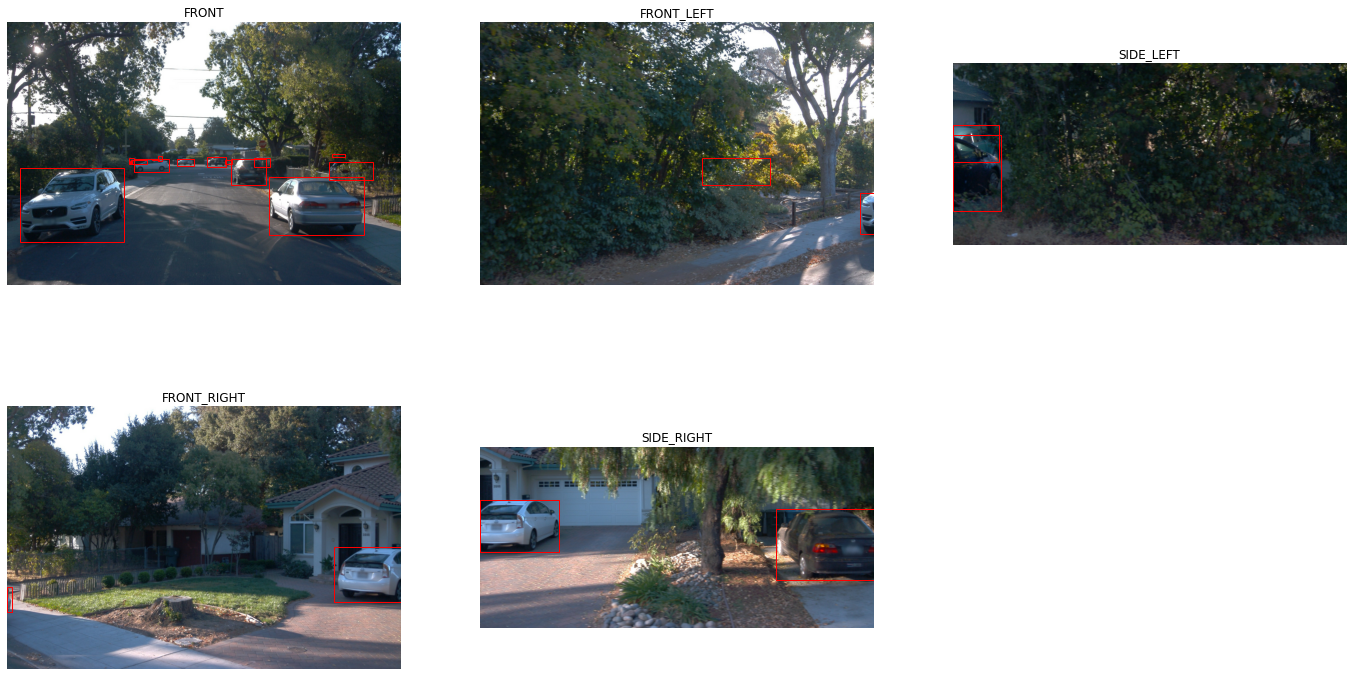

In [44]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

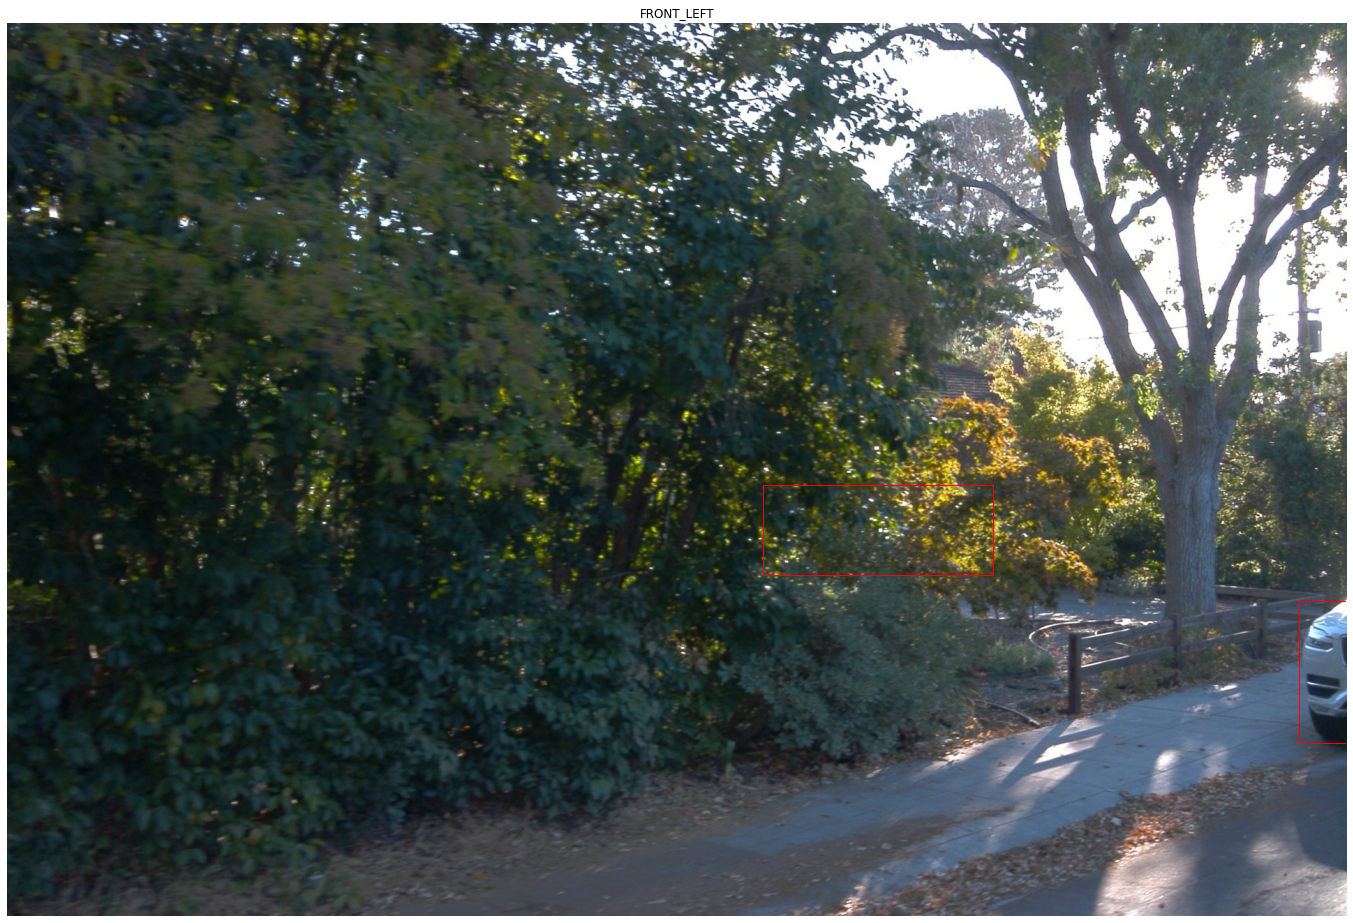

In [45]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    if open_dataset.CameraName.Name.Name(image.name) == 'FRONT_LEFT':
        show_camera_image(image, frame.camera_labels, [1, 1, 1])

In the above frame captured by the `FRONT_LEFT` camera we see that there has been a bounding box incorrectly placed over an area of foliage. No object appears to exist at the location of the bounding box.

#### Missing annotations

In [46]:
### Setting the gsutil variables
bucket_name = 'waymo_open_dataset_v_1_2_0_individual_files/validation/'
file_name = 'segment-1943605865180232897_680_000_700_000_with_camera_labels.tfrecord'

In [47]:
!gsutil cp "{'gs://' + bucket_name + file_name}" "{DIR_SRC}"

Copying gs://waymo_open_dataset_v_1_2_0_individual_files/validation/segment-1943605865180232897_680_000_700_000_with_camera_labels.tfrecord...
\ [1 files][856.6 MiB/856.6 MiB]   68.8 MiB/s                                   
Operation completed over 1 objects/856.6 MiB.                                    


In [48]:
local_path = os.path.join(DIR_SRC, file_name)
frame = get_frame(local_path, camera_name='FRONT', frame_nr=73)
image, annotations = parse_frame(frame, camera_name='FRONT')

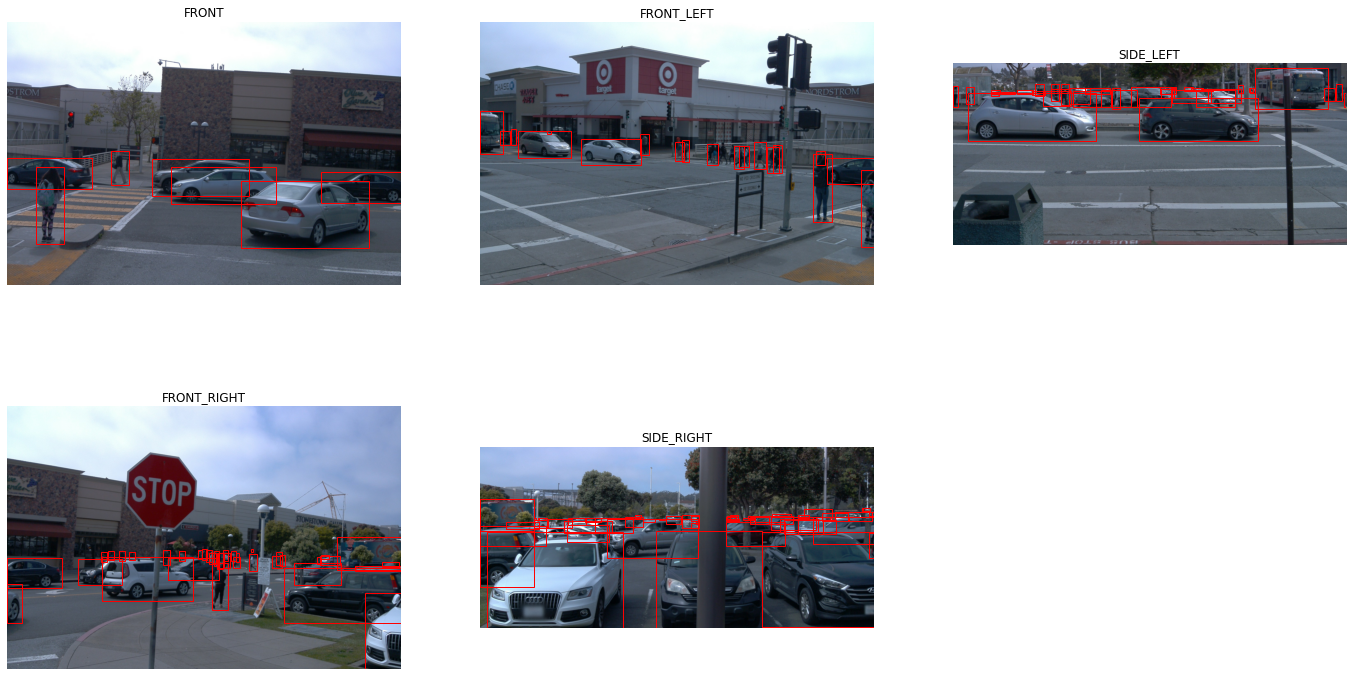

In [49]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

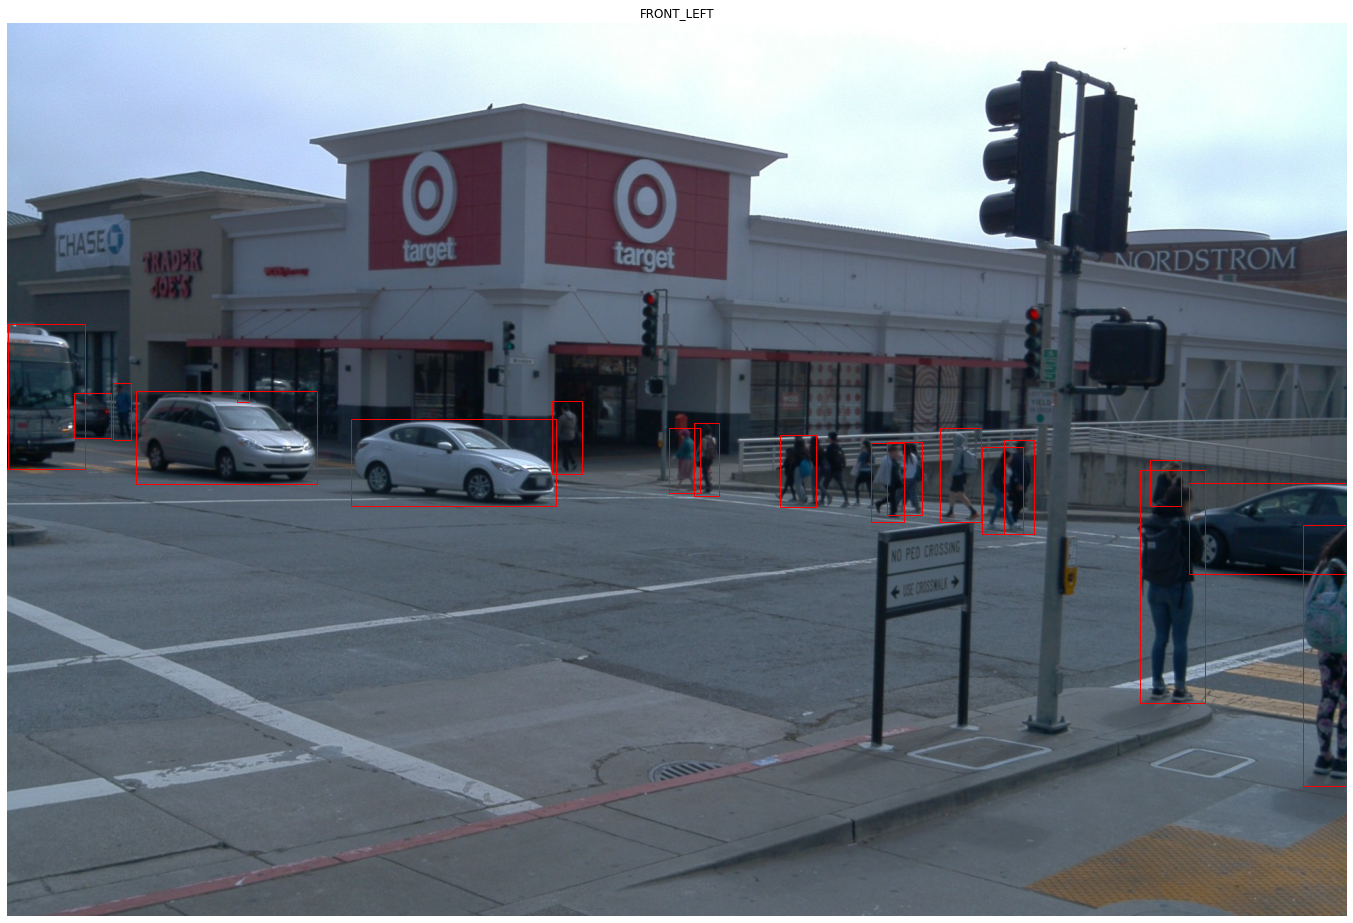

In [50]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    if open_dataset.CameraName.Name.Name(image.name) == 'FRONT_LEFT':
        show_camera_image(image, frame.camera_labels, [1, 1, 1])

In this clip, we see that there are two pedestrians in the middle of the pedestrian crossing making their way to the [Target at Stonestown Mall](https://goo.gl/maps/WsH9oxeuNp3xwb5X8). For the entire duration of time that the Waymo Driver sat at this intersection (20+ frames), the two pedestrians were not detected and assigned proper bounding boxes. This is especially concerning given that in this scene we are at a densely-populated shopping mall located adjacent to the San Francisco State University. Failing to detect just one of these pedestrians in a real-world setting could be fatal. 

We expect high-quality labels in the Waymo Open Dataset, especially when it comes to pedestrians.

In [51]:
### Setting the gsutil variables
bucket_name = 'waymo_open_dataset_v_1_2_0_individual_files/validation/'
file_name = 'segment-15224741240438106736_960_000_980_000_with_camera_labels.tfrecord'

In [52]:
!gsutil cp "{'gs://' + bucket_name + file_name}" "{DIR_SRC}"

Copying gs://waymo_open_dataset_v_1_2_0_individual_files/validation/segment-15224741240438106736_960_000_980_000_with_camera_labels.tfrecord...
- [1 files][905.6 MiB/905.6 MiB]   67.7 MiB/s                                   
Operation completed over 1 objects/905.6 MiB.                                    


In [53]:
local_path = os.path.join(DIR_SRC, file_name)
frame = get_frame(local_path, camera_name='FRONT', frame_nr=100)

In [54]:
image, annotations = parse_frame(frame, camera_name='FRONT')

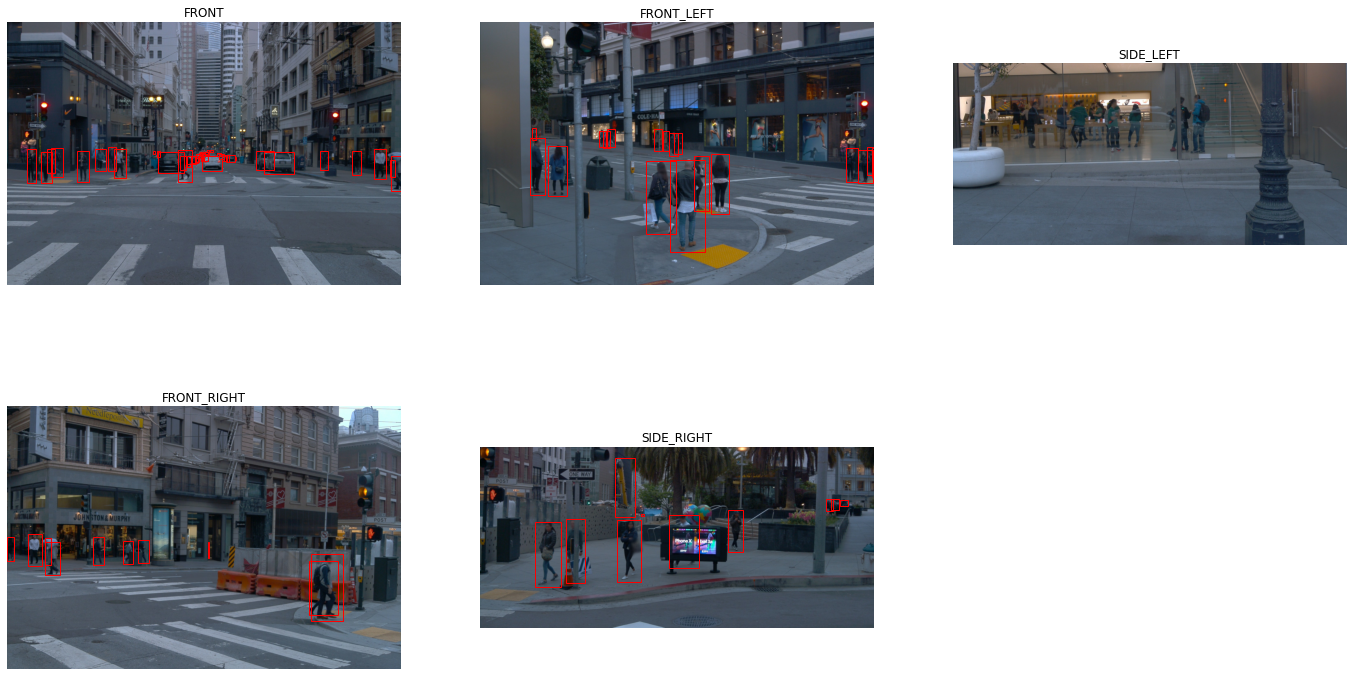

In [55]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

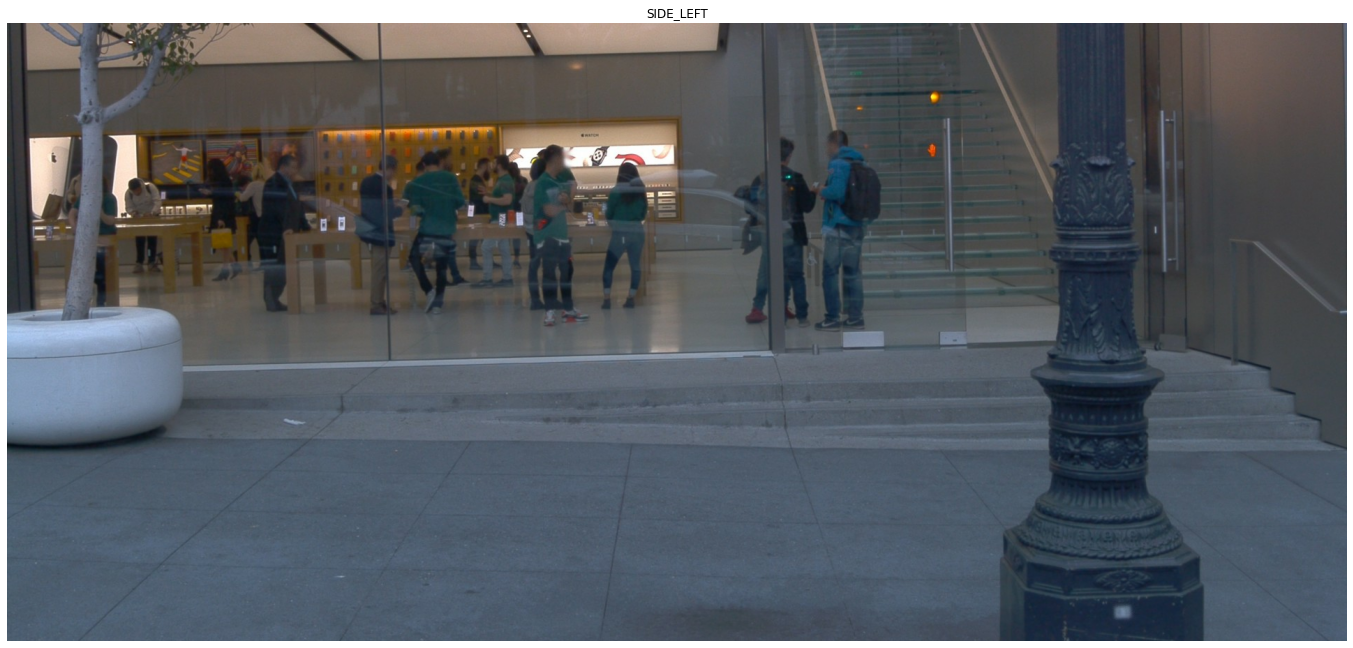

In [56]:
plt.figure(figsize=(24,20))
for index, image in enumerate(frame.images):
    if open_dataset.CameraName.Name.Name(image.name) == 'SIDE_LEFT':
        show_camera_image(image, frame.camera_labels, [1, 1, 1])

In this clip we see a number of people without corresponding bounding boxes annotations. However, unlike the previous clips, these people are behind a glass wall at what appears to be an Apple Store in an urban city. These people aren't necessarily interacting within the driving environment or located on/near the road surface. Therefore, I'm not entirely sure they are erroneously mislabelled.

### Visualising LiDAR data

We will leave this task to the reader for now. 

For those interested: one suggestion would be to visualise the distances of objects from the ego vehicle; another suggestion would be to visualise relative dimensions of the objects, taking into account their class (pedestrian, cyclist, sign, etc.). These findings can inform the selection of interesting training examples for a specific use case e.g., pedestrians crossing in front of or behind the ego vehicle, cyclists biking in close proximity to the sides of the ego vehicle, etc. Note that the provided `.csv` file does not include the 3D LiDAR data necessary for this task, but the curious reader should have no difficulty obtaining these measurements with only slight modifications to the [original script file](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/56697b2b7572acb9ff10f2606173ad45dcc8aa23/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments/scripts/data_analysis/2022-10-08-Downloading-and-Extracting-Data.ipynb).

## 3. Closing Remarks

##### Alternatives
* Can use interactive plotting libraries (e.g., [Plotly](https://plotly.com/python/)) to create dynamic figures with data labels;
* Can fetch additional data from the Google Cloud Storage bucket to use in follow-up study on weather conditions and their representation across the entire dataset.

##### Extensions of task
* Visualise the 3D LiDAR data in an overlaid point cloud rendering;
* Visualise the object detections relative to the ego vehicle (e.g., scatter plot of objects at distance away from ego vehicle);
* Perform further analyses on object data (e.g., look at distribution of object dimensions, segment pedestrians into bins by height, find interesting scenes by searching for specific attribute values — object distance, position in 3D, etc.).

## 4. Future Work

- ⬜️ Download more `segment` files with diverse weather conditions (e.g., rain, fog, snow, etc.);
- ⬜️ Look at object distances relative to the ego vehicle;
- ⬜️ Find and correct for more missing/incorrect annotations in the dataset.

## Credits

This assignment was prepared by Thomas Hossler and Michael Virgo et al., Winter 2021 (link [here](https://github.com/udacity/nd013-c1-vision-starter)).

References
* [1] Sun, Pei, et al. "Scalability in Perception for Autonomous Driving: Waymo Open Dataset." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). 2020. https://waymo.com/open. [doi:10.48550/arXiv.1912.04838](https://arxiv.org/abs/1912.04838)


Helpful resources:
* [`2022-10-08-Downloading-and-Extracting-Data.ipynb` by Jonathan L. Moran (@jonathanlmoran) | GitHub](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/1-1-Object-Detection-2D/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments/scripts/data_analysis/2022-10-08-Downloading-and-Extracting-Data.ipynb)
* [Exercise 1.1.3: Creating `TFRecord`s by Jonathan L. Moran (@jonathanloganmoran) | GitHub](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/1-1-Object-Detection-2D/1-Computer-Vision/Exercises/1-1-3-Creating-TF-Records/2022-08-03-Creating-TF-Records.ipynb)